# Data loading and libraries loading


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM1_B0A104.csv"

In [3]:
dataset = pd.read_csv(url)

In [4]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,0.066284,-0.533936,0.815063,-1.663208,0.289917,1.922607
1,0.066162,-0.534058,0.815796,-1.663208,0.305176,1.922607
2,0.066650,-0.533447,0.815430,-1.663208,0.305176,1.907349
3,0.066528,-0.533569,0.815063,-1.678467,0.305176,1.907349
4,0.067871,-0.533325,0.814819,-1.678467,0.289917,1.892090


In [5]:
dataset.accel_x[0]

0.0662841796875

__Acceleration plot__

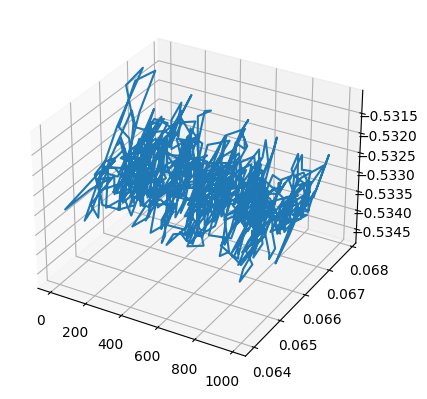

In [6]:
ax = plt.axes(projection='3d')
t = np.arange(0, dataset.accel_z.size, 1)
zline = dataset.accel_z
xline = dataset.accel_x
yline = dataset.accel_y
ax.plot3D(t, xline, yline, zline)

*Не слишком информативно(*

# Integration of the acceleration


Here I'm going to approximate an integral by rectangles beneath the curve


In [7]:
TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
DISPLACEMENTS = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

In [8]:
def integrate(acceleration_data, times):
    # 1. We will need to keep track of the total accumulated speed
    accumulated_speed = 0.0

    # 2.
    last_time = times[0]
    speeds = []

    # 3. Once again, we lose some data because we have to start
    #    at i=1 instead of i=0.
    for i in range(1, len(times)):

        # 4. Get the numbers for this index i
        acceleration = acceleration_data[i]
        time = times[i]

        # 5. Calculate delta t
        delta_t = time - last_time

        # 6. This is an important step! This is where we approximate
        #    the area under the curve using a rectangle w/ width of
        #    delta_t.
        delta_v = acceleration * delta_t

        # 7. The actual speed now is whatever the speed was before
        #    plus the new change in speed.
        accumulated_speed += delta_v

        # 8. append to speeds and update last_time
        speeds.append(accumulated_speed)
        last_time = time
    return speeds

In [9]:
def get_pos_plot(ACCELERATIONS, TIMESTAMPS, DISPLACEMENTS):
  # 9. Now we use the function we just defined
  integrated_speeds_x = integrate(ACCELERATIONS[0], TIMESTAMPS)
  integrated_displ_x = integrate(integrated_speeds_x,
                                                  TIMESTAMPS[1:])
  for i in range(0, len(integrated_displ_x)):
    integrated_displ_x[i] += DISPLACEMENTS[0][i]

  integrated_speeds_y = integrate(ACCELERATIONS[1], TIMESTAMPS)
  integrated_displ_y = integrate(integrated_speeds_y,
                                                  TIMESTAMPS[1:])
  for i in range(0, len(integrated_displ_y)):
    integrated_displ_y[i] += DISPLACEMENTS[1][i]

  integrated_speeds_z = integrate(ACCELERATIONS[2], TIMESTAMPS)
  integrated_displ_z = integrate(integrated_speeds_z,
                                                  TIMESTAMPS[1:])
  for i in range(0, len(integrated_displ_z)):
    integrated_displ_z[i] += DISPLACEMENTS[2][i]

  ax = plt.axes(projection='3d')
  ax.plot3D(integrated_displ_x, integrated_displ_y, integrated_displ_z)

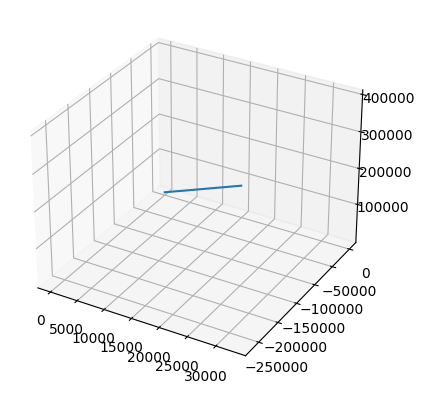

In [10]:
get_pos_plot(ACCELERATIONS, TIMESTAMPS, DISPLACEMENTS)

# New Dataset


In [11]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM1_B1A104.csv"
dataset_1 = pd.read_csv(url)

In [12]:
TIMESTAMPS    = np.arange(0, dataset_1.accel_z.size, 1)
DISPLACEMENTS = [dataset_1.gyro_x, dataset_1.gyro_y, dataset_1.gyro_z]
ACCELERATIONS = [dataset_1.accel_x, dataset_1.accel_y, dataset_1.accel_z]

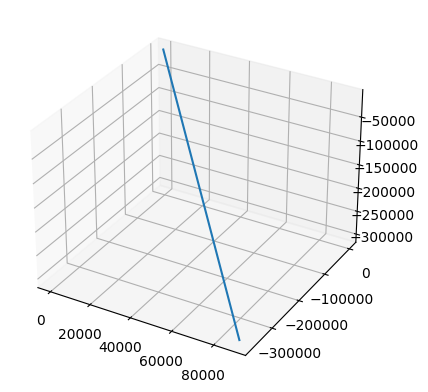

In [13]:
get_pos_plot(ACCELERATIONS, TIMESTAMPS, DISPLACEMENTS)

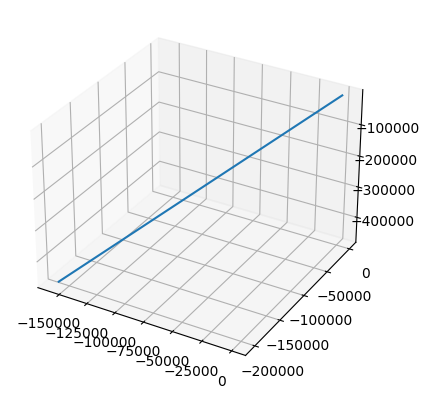

In [15]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM2_B1A105.csv"
dataset_1 = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset_1.accel_z.size, 1)
DISPLACEMENTS = [dataset_1.gyro_x, dataset_1.gyro_y, dataset_1.gyro_z]
ACCELERATIONS = [dataset_1.accel_x, dataset_1.accel_y, dataset_1.accel_z]

get_pos_plot(ACCELERATIONS, TIMESTAMPS, DISPLACEMENTS)

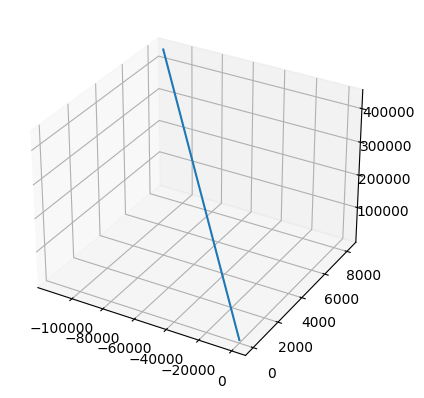

In [14]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM2_B0A104.csv"
dataset_1 = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset_1.accel_z.size, 1)
DISPLACEMENTS = [dataset_1.gyro_x, dataset_1.gyro_y, dataset_1.gyro_z]
ACCELERATIONS = [dataset_1.accel_x, dataset_1.accel_y, dataset_1.accel_z]

get_pos_plot(ACCELERATIONS, TIMESTAMPS, DISPLACEMENTS)